In [ ]:
# default_exp autoforest

# module name here

> API details.

In [1]:
#export
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import sklearn.ensemble as forest
import GPyOpt
import GPy
import math
import scipy
from scipy.cluster import hierarchy as hc

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
filename = "Train_cleaned.csv"           # dataframe containing all the data
y_col_name = 'SalePrice'         # name of the column we are going to predict
split_pct = 0.2             # size of verification dataset
max_train_time_s = 20         # maximum runtime for one epoch of the data. If it takes longer, the data is cut during search
time_series = False          # used for validation set, if true, the last split_pct is used, otherwize, random sampled validation
max_iter = 50             # maximum number of tries to find optimal hyper parameters
nfold = 3                 #number of tests for each set of hyper-parameters to get a more stable result

In [4]:
df = pd.read_csv(filename,low_memory=False)

# Handle Data

In [5]:
#export
def split_data(df_x, df_y, pct):
    "Splits the data into train and validation set"
    " pct: 0-1 depending on how much that is in validation set"
    df_x.reset_index(inplace=True, drop=True)
    df_y.reset_index(inplace=True, drop=True)

    l = int(len(df_x) * pct)
    x_train = df_x.iloc[:-l]
    x_valid = df_x.iloc[-l:]
    y_train = df_y.iloc[:-l]
    y_valid = df_y.iloc[-l:]
    return x_train, y_train, x_valid, y_valid

def split_data_by_time(df, sampled_time=0, max_train_time_s=np.inf):
    """
    splits the data into smaller size if it takes too long to make one test-run
    """
    if not time_series:
        df = df.sample(frac=1.0).reset_index(drop=True)
    if max_train_time_s < sampled_time:
        psamp = max_train_time_s/sampled_time
        df_samp = df.sample(frac = psamp)
        print(f'Pruning data to len: {len(df)}')
    else:
        df_samp = df
    df_y_samp = df_samp[y_col_name]
    df_x_samp = df_samp.drop(y_col_name, axis=1)
    return  split_data(df_x_samp, df_y_samp, split_pct)

In [6]:
x_train, y_train, x_valid, y_valid = split_data_by_time(df, sampled_time=10, max_train_time_s = 5)
assert len(x_train) + len(x_valid) == len(df)//2
x_train, y_train, x_valid, y_valid = split_data_by_time(df)
assert len(x_train) + len(x_valid) == len(df)

data = split_data_by_time(df)
assert len(data) == 4

Pruning data to len: 401125


In [7]:
#export
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m, data):
    x_train, y_train, x_valid, y_valid = data
    res = [rmse(m.predict(x_train), y_train), 
           rmse(m.predict(x_valid), y_valid),
                m.score(x_train, y_train), 
                m.score(x_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        extra = f' oob_score_:{m.oob_score_}'
    else:
        extra = ''
        
    print(f'rmse t:{res[0]}, rmse v:{res[1]} score t:{res[2]} score v:{res[3]}'+extra)
    return res[1]

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [23]:
#export
def run_rf_regressor(data,min_sample_leaf:int=4, n_estimators:int=40, sample_frac:float=0.2, max_features:float=0.5):
    """
    todo, set max num samples to speed up the classification
    """
    x_train, y_train, x_valid, y_valid = data
    set_rf_samples(int(len(x_train)*sample_frac))
    m = RandomForestRegressor(n_estimators=n_estimators, 
                              n_jobs=-1,
                              oob_score=True, 
                              min_samples_leaf=min_sample_leaf,
                              max_features=max_features)
    m.fit(x_train, y_train)
    rmse_valid = print_score(m,data)
    return rmse_valid, m

In [9]:
#export
def predict(m, df):
    preds = np.stack([t.predict(df) for t in m.estimators_])
    conf = np.std(preds, axis=0)
    pred = np.mean(preds,axis=0)
    return pred,conf

In [24]:
res, m = run_rf_regressor(data)

rmse t:0.13524997042106074, rmse v:0.20674924991151286 score t:0.9620121186027443 score v:0.9108347312800409 oob_score_:0.9080081090708079


In [25]:
#export

def get_tree_confidence(m, x_data):
    # returns rmse for validation set (% error) and std(confidence) among the estimators of the tree
    preds = np.stack([t.predict(x_data) for t in m.estimators_])
    stds = np.std(preds,axis=0)
    return stds.mean()

In [26]:
preds, conf = predict(m, x_valid)
tree_conf = get_tree_confidence(m, x_valid)

assert conf.mean() ==tree_conf

# Feature Importance

In [31]:
#export
def rf_feat_importance(m, df):
    """ returns a dataframe containing all columns together with feature importance"""
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def rf_plot_fi(df_fi): 
    return df_fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [35]:
df_imp = rf_feat_importance(m, df.drop(y_col_name,axis=1))
df_imp.head()

,cols,imp
6,YearMade,0.173210
38,Coupler_System,0.110159
14,ProductSize,0.104233
15,fiProductClassDesc,0.081046
3,ModelID,0.054392


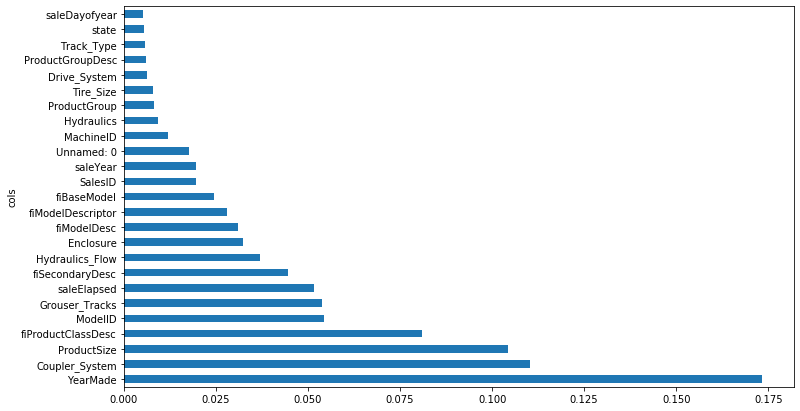

In [36]:
df_imp = df_imp[df_imp['imp']>0.005]
rf_plot_fi(df_imp)

# Highly Correlated Variables
Variables that gives the same information (but might be x and log(x)) can confuse the model and need to be removed.
This is a way to find the variables

In [37]:
def rf_get_correlation_matrix(df):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    return corr

In [38]:
def rf_plot_var_linkage(corr):
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(16,10))
    dendrogram = hc.dendrogram(z, labels=df_pruned.columns, orientation='left', leaf_font_size=16)
    plt.show()

### graph explanation
The graph below tells us the correlation of parameters in the input dataset.
Sale_Year and saleElapsed are almost identical, Unnamed:0 and SalesID are also highly similar

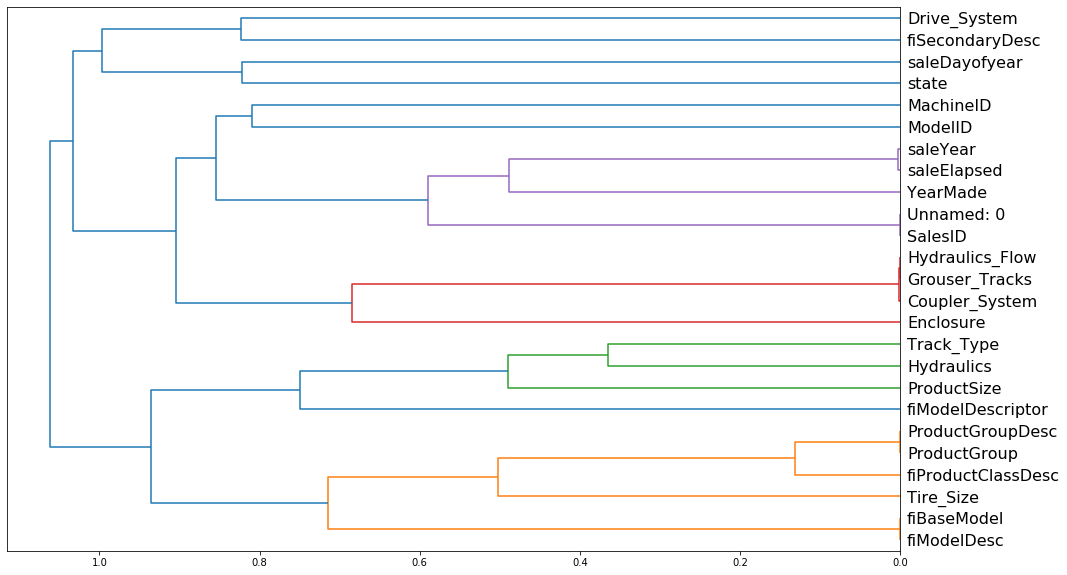

In [66]:
df_pruned = df[df_imp['cols']].copy()
corr = rf_get_correlation_matrix(df_pruned)
rf_plot_var_linkage(corr)

In [78]:
#export
def _get_list_of_high_corr(corr ,corr_limit):
    p = np.argwhere(np.triu(corr>corr_limit,1))
    l = list(p)
    return l
    
def _del_param_in_array(arr, value):
    for i in range(len(arr)-1,0,-1):
        if arr[i-1][0] == value:
            del arr[i-1]
            
def _del_duplicated_columns(arr):
    i=0
    while(i<len(arr)):
        _del_param_in_array(arr,arr[i][1])
        i+=1
    return arr
# todo, fix this to return an array of arrays instead of dict
def _arrays_to_colnames(arr,df):
    data = dict()
    for i in range(len(arr)):
        temp = data.get(arr[i][0],list())
        if len(temp)==0:
            colname = df.columns[arr[i][0]]
            temp.append(colname)
        colname = df.columns[arr[i][1]]
        temp.append(colname)
        data[arr[i][0]]  = temp
    return data
    
def get_pairs(df, corr_limit = 0.98):
    corr = rf_get_correlation_matrix(df)
    l = _get_list_of_high_corr(corr, corr_limit)
    _del_duplicated_columns(l)
    
    return _arrays_to_colnames(l, df)
    

In [79]:
get_pairs(df_pruned)

{1: ['Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow'],
 6: ['saleElapsed', 'saleYear'],
 10: ['fiModelDesc', 'fiBaseModel'],
 13: ['SalesID', 'Unnamed: 0'],
 18: ['ProductGroup', 'ProductGroupDesc']}

# gpyopt optimizer

In [87]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
